# The stacked model

In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from math import sqrt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

import pickle

matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

__Notice:__ In `sklearn` Polynomial Regression is defined indirectly.
First, you have to obtain polynomial features to linearaze data and then fit with vanilla `LinearRegression`
```python
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
```
  

In [2]:
# Import the dataset
data = pd.read_csv('Data_training.csv', index_col = 0)
data.columns = ['Tg', 'Tk', 'n', 'damage']

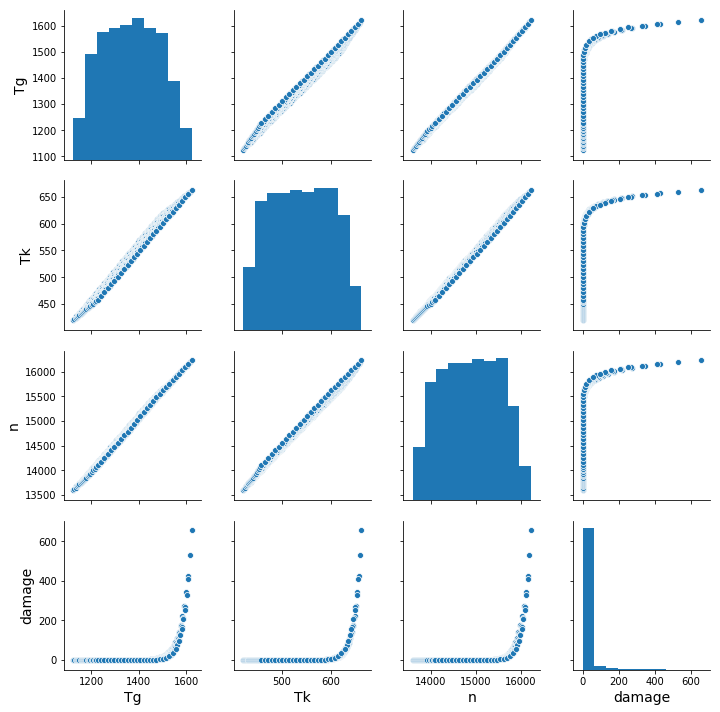

In [3]:
# Basic EDA
sns.pairplot(data)

In [40]:
# Normalization
scaler = MinMaxScaler()
scaler.fit(data)

pickle.dump(scaler, open('scaler.pkl', 'wb')) # save fitted scaler
# scaler = pickle.load(open('scaler.pkl', 'rb')) # load it back

data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled.loc[:, ['Tg', 'Tk', 'n']], data_scaled['damage'], test_size=0.2, random_state=42)

In [49]:
# Define function for CV for "weak" models
def Stacking(model, train, y, test, n_fold, is_poly_reg = False):
    folds = KFold(n_splits = n_fold, random_state = 42)
    test_pred = np.empty((test.shape[0], 1), float)
    train_pred = np.empty((0, 1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        x_train, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        if is_poly_reg == True:
            poly_reg = PolynomialFeatures(degree=3)
            x_poly = poly_reg.fit_transform(x_train)
            model.fit(x_poly, y_train)
        else:
            model.fit(X = x_train, y = y_train, eval_set = [(x_val, y_val)])
            
        train_pred = np.append(train_pred, model.predict(x_val))
        test_pred = np.append(test_pred, model.predict(test))
    return test_pred.reshape(-1, 1), train_pred, model

In [58]:
# Define lightGBM model
model1 = LGBMRegressor(boosting_type = 'gbdt',
                       num_leaves = 10,
                       metric = 'rmse',
                       n_estimators = 1000,
                       early_stopping_rounds = 100,
                       # device = 'gpu',
                       n_jobs = -1,
                       random_state = 42,
                       verbose = -1)

# Create the random grid
model1_param_grid = {'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                     'num_leaves': [10, 20, 30]}

model1_rs = RandomizedSearchCV(estimator = model1,
                               param_distributions = model1_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [59]:
# Define linear model for polynomial regression
model2 = LinearRegression(n_jobs = -1)

In [60]:
# Define CatBoost model
model3 = CatBoostRegressor(loss_function='RMSE',
                           random_seed = 42,
                           task_type = 'GPU',
                           # boosting_type = 'Plain', # set if it exceeds RAM
                           # params for early stopping:
                           iterations = 1000,
                           od_type = 'Iter',
                           od_wait = 100,
                           silent = True)

# Create the random grid
model3_param_grid = {'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                     'depth': [int(x) for x in np.linspace(2, 8, num = 4)]}

model3_rs = RandomizedSearchCV(estimator = model3,
                               param_distributions = model3_param_grid,
                               n_iter=10, cv=3, verbose=0)

In [ ]:
# Train "weak" models
test_pred1, train_pred1, lightgbm_model = Stacking(model = model1_rs, n_fold = 10, train = X_train, test = X_test, y = y_train)
test_pred1, train_pred1 = pd.DataFrame(test_pred1), pd.DataFrame(train_pred1)
pickle.dump(lightgbm_model, open('lightgbm_model.pkl', 'wb')) # save the fitted model

test_pred2, train_pred2, polynom_reg_model = Stacking(model = model2, n_fold = 10, train = X_train, test = X_test, y = y_train)
test_pred2, train_pred2 = pd.DataFrame(test_pred2), pd.DataFrame(train_pred2)
pickle.dump(polynom_reg_model, open('polynom_reg_model.pkl', 'wb')) # save the fitted model

test_pred3, train_pred3, catboost_model = Stacking(model = model3_rs, n_fold = 10, train = X_train, test = X_test, y = y_train)
test_pred3, train_pred3 = pd.DataFrame(test_pred3), pd.DataFrame(train_pred3)
pickle.dump(catboost_model, open('catboost_model.pkl', 'wb')) # save the fitted model

[1]	valid_0's rmse: 0.0207754
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.0201528
[3]	valid_0's rmse: 0.0192268
[4]	valid_0's rmse: 0.0186575
[5]	valid_0's rmse: 0.0178214
[6]	valid_0's rmse: 0.0172984
[7]	valid_0's rmse: 0.0165556
[8]	valid_0's rmse: 0.0160656
[9]	valid_0's rmse: 0.0153983
[10]	valid_0's rmse: 0.0149584
[11]	valid_0's rmse: 0.014377
[12]	valid_0's rmse: 0.013964
[13]	valid_0's rmse: 0.0134372
[14]	valid_0's rmse: 0.0130985
[15]	valid_0's rmse: 0.0126283
[16]	valid_0's rmse: 0.0123234
[17]	valid_0's rmse: 0.0119205
[18]	valid_0's rmse: 0.0116395
[19]	valid_0's rmse: 0.0112909
[20]	valid_0's rmse: 0.0110169
[21]	valid_0's rmse: 0.0107458
[22]	valid_0's rmse: 0.0105165
[23]	valid_0's rmse: 0.0102701
[24]	valid_0's rmse: 0.0100769
[25]	valid_0's rmse: 0.00987058
[26]	valid_0's rmse: 0.00968943
[27]	valid_0's rmse: 0.00952446
[28]	valid_0's rmse: 0.00937572
[29]	valid_0's rmse: 0.00924658
[30]	valid_0's rmse: 0.00910355
[31]	valid_0

In [ ]:
# Create "strong" model over "weak" predictions
train_preds = pd.concat([train_pred1, train_pred2, train_pred3], axis = 1)
test_preds = pd.concat([test_pred1, test_pred2, train_pred3], axis = 1)

strong_model = xgb.XGBRegressor(eval_metric = "rmse",
                                min_child_weight=1.5,                                                                  
                                # reg_alpha=0.75,
                                # reg_lambda=0.45,
                                n_estimators = 10000,
                                early_stopping_rounds = 100,
                                eval_set = [(X_test, y_test)]
                                kvargs = {'tree_method':'gpu_hist'}, # enable GPU
                                seed = 42)

# Create the random grid
strong_model_param_grid = {'colsample_bytree': [0.4, 0.6, 0.8]
                           'learning_rate': [x for x in np.linspace(0.001, 0.05, num = 5)],
                           'max_depth': [int(x) for x in np.linspace(2, 8, num = 4)],
                           'num_leaves': [10, 20, 30]}

strong_model = RandomizedSearchCV(estimator = strong_model,
                                  param_distributions = strong_model_param_grid,
                                  n_iter=20, cv=3, verbose=0)

strong_model.fit(train_preds, y_train)
pickle.dump(strong_model, open('xgbr_strong_model.pkl', 'wb')) # save the fitted model

y_pred_test = strong_model.predict(test_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred_test, y_test))}")

Visualize the result metrics

In [ ]:
def plot_true_vs_pred(y_pred, y_test, title_text):
    plt.figure(figsize=(6, 6))

    plt.title(title_text, y=1.01, fontsize=19, fontweight='bold')
    sns.scatterplot(x = y_pred, y = y_test, color='red', s=100)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black', linestyle='dashed')
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    plt.text(0.17, 0.8, f'$RMSE={round(rmse, 2)}$', fontsize=12, fontweight='bold')

    plt.ylabel('$Damage_{true}$', fontsize = 15)
    plt.xlabel('$Damage_{pred}$', fontsize = 15)

    plt.grid()
    plt.show()

In [ ]:
def plot_true_minus_pred(y_pred, y_test, title_text):
    plt.figure(figsize=(8, 6))
    plt.title(title_text, y=1.01, fontsize = 20, fontweight='bold')
    sns.distplot((y_test - y_pred), kde=True, norm_hist=True, color='red')

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    plt.text(-0.15, 450, f'$RMSE={round(rmse, 2)}$', fontsize=12, fontweight='bold')

    plt.ylabel('$Occurence$', fontsize = 15)
    plt.xlabel('$Damage_{true}$ - $Damage_{pred}$', fontsize = 15)

    plt.grid()
    plt.show()

In [ ]:
plot_true_vs_pred(y_pred_test, y_test, "Stacked model")

In [ ]:
plot_true_minus_pred(y_pred_test, y_test, "Stacked model")

How to re-use the pre-trained model

In [ ]:
# Import the new dataset
data = pd.read_csv('Data_training.csv', index_col = 0)
data.columns = ['Tg', 'Tk', 'n', 'damage']

# Normalize the data
scaler = pickle.load(open('scaler.pkl', 'rb'))
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

# Make inference
x = data.loc[:, ['Tg', 'Tk', 'n']]
y_true = data['damage']

model1 = pickle.load(open('lightgbm_model.pkl', 'rb'))
model2 = pickle.load(open('polynom_reg_model.pkl', 'rb'))
model3 = pickle.load(open('catboost_model.pkl', 'rb'))
strong_model = pickle.load(open('xgbr_strong_model.pkl', 'rb'))

model1_preds = model1.predict(x)
model2_preds = model2.predict(x)
model3_preds = model3.predict(x)

models_preds = pd.concat([model1_preds, model2_preds, model3_preds], axis = 1)

y_pred = strong_model.predict(models_preds)
print(f"RMSE score for stacked model: {sqrt(mean_squared_error(y_pred, y_true))}")